In [13]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import namedtuple, deque
import torch.optim as optim
import datetime
import gym
from gym.wrappers.record_video import RecordVideo
import glob
import io
import base64
import matplotlib.pyplot as plt
from IPython.display import HTML
from pyvirtualdisplay import Display
import tensorflow as tf
from IPython import display as ipythondisplay
from PIL import Image
import tensorflow_probability as tfp

In [14]:
env = gym.make('CartPole-v1')
# env.seed(0)

state_shape = env.observation_space.shape[0]
no_of_actions = env.action_space.n

print(state_shape)
print(no_of_actions)
print(env.action_space.sample())
print("----")

'''
# Understanding State, Action, Reward Dynamics

The agent decides an action to take depending on the state.

The Environment keeps a variable specifically for the current state.
- Everytime an action is passed to the environment, it calculates the new state and updates the current state variable.
- It returns the new current state and reward for the agent to take the next action

'''

state = env.reset()
''' This returns the initial state (when environment is reset) '''

print(state)
print("----")

action = env.action_space.sample()
''' We take a random action now '''

print(action)
print("----")

next_state, reward, done, _, info = env.step(action)
''' env.step is used to calculate new state and obtain reward based on old state and action taken  '''

print(next_state)
print(reward)
print(done)
print(info)
print("----")

TAU = 0

4
2
1
----
(array([-0.00919449,  0.01528829, -0.04272228, -0.03958981], dtype=float32), {})
----
1
----
[-0.00888873  0.21099602 -0.04351408 -0.34544006]
1.0
False
{}
----


In [15]:
###################################### DUELING DQN with MEAN ########################################
class MeanDuelingDQN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden, seed):
        super(MeanDuelingDQN, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.feature_extraction = nn.Sequential(
            nn.Linear(self.input_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 64),
            nn.ReLU()
        )

        self.value_stream = nn.Sequential(
            # nn.Linear(128, 128),
            # nn.ReLU(),
            nn.Linear(64, 1)
        )

        self.advantage = nn.Sequential(
            # nn.Linear(128, 128),
            # nn.ReLU(),
            nn.Linear(64, self.output_dim)
        )

    def forward(self, state):
        features = self.feature_extraction(state)
        values = self.value_stream(features)
        advantages = self.advantage(features)
        qvals = values + (advantages - advantages.mean())
    
        return qvals

######################################################################################################
    
###################################### DUELING DQN with MAX ########################################

class MaxDuelingDQN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden, seed):
        super(MaxDuelingDQN, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.feature_extraction = nn.Sequential(
            nn.Linear(self.input_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 64),
            nn.ReLU()
        )

        self.value_stream = nn.Sequential(
            # nn.Linear(128, 128),
            # nn.ReLU(),
            nn.Linear(64, 1)
        )

        self.advantage = nn.Sequential(
            # nn.Linear(128, 128),
            # nn.ReLU(),
            nn.Linear(64, self.output_dim)
        )

    def forward(self, state):
        features = self.feature_extraction(state)
        values = self.value_stream(features)
        advantages = self.advantage(features)
        qvals = values + (advantages - advantages.max())
    
        return qvals
######################################################################################################

In [16]:
################################## REPLAY BUFFER #########################################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [17]:
class Agent():

    def __init__(self, state_size, action_size, seed, DuelingDQN, hidden = 128):

        ''' Agent Environment Interaction '''
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        ''' Q-Network '''
        self.qnetwork_local = DuelingDQN(state_size, action_size, hidden, seed).to(device)
        self.qnetwork_target = DuelingDQN(state_size, action_size, hidden, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        ''' Replay memory '''
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)

        ''' Initialize time step (for updating every UPDATE_EVERY steps)           -Needed for Q Targets '''
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):

        ''' Save experience in replay memory '''
        self.memory.add(state, action, reward, next_state, done)

        ''' If enough samples are available in memory, get random subset and learn '''
        if len(self.memory) >= BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

        """ +Q TARGETS PRESENT """
        ''' Updating the Network every 'UPDATE_EVERY' steps taken '''
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:

            self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

    def act(self, state, eps=0.):

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        ''' Epsilon-greedy action selection (Already Present) '''
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """ +E EXPERIENCE REPLAY PRESENT """
        states, actions, rewards, next_states, dones = experiences

        ''' Get max predicted Q values (for next states) from target model'''
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        ''' Compute Q targets for current states '''
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        ''' Get expected Q values from local model '''
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        ''' Compute loss '''
        loss = F.mse_loss(Q_expected, Q_targets)

        ''' Minimize the loss '''
        self.optimizer.zero_grad()
        loss.backward()

        ''' Gradiant Clipping '''
        """ +T TRUNCATION PRESENT """
        for param in self.qnetwork_local.parameters():
            param.grad.data.clamp_(-1, 1)

        self.optimizer.step()
        # self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU) 
    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)

In [18]:
import matplotlib.pyplot as plt

def dqn(env, agent, threshold, n_episodes=500, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, tau = 0.1):
    scores_window = deque(maxlen=100)
    scores_array = []
    eps = eps_start
    reward_sat=False
    reahced_flag = False
    for i_episode in range(1, n_episodes + 1):
        state = env.reset()[0]
        # print(state)
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _, _ = env.step(action)
            if not reward_sat:
                agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break

        scores_window.append(score)
        scores_array.append(np.mean(scores_window))
        eps = max(eps_end, eps_decay * eps)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")

        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window) >= threshold and not reahced_flag:
            reahced_flag = True
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            reward_sat=True

    return scores_array

In [19]:
def run_agent(env, DuelingDQN, state_shape, action_shape, threshold, max_t , hidden = 128):
    # Trial run to check if the algorithm runs and saves the data
    begin_time = datetime.datetime.now()

    # Assuming env, TutorialAgent, and other required variables are defined
    agent = Agent(state_size=state_shape, action_size=action_shape, seed=np.random.randint(1,100), DuelingDQN = DuelingDQN, hidden = hidden)
    scores_array = dqn(env, agent, threshold, max_t=max_t)

    time_taken = datetime.datetime.now() - begin_time
    print(time_taken)

    return scores_array, agent

In [20]:
# mean_scores, mean_agent = run_agent(env, MeanDuelingDQN, state_shape, action_shape)

In [21]:
def plot_rewards(all_rewards_1, all_rewards_2, name):
    """
    Plots the rewards for Mean Dueling DQN and Max Dueling DQN over episodes.
    
    Parameters:
    all_rewards_1 (list): List of rewards for Mean Dueling DQN.
    all_rewards_2 (list): List of rewards for Max Dueling DQN.
    name (str): Name of the environment.
    
    Returns:
    None
    """
    average_rewards = []
    for i in range(0, len(all_rewards)):
        if i < 100:
            average_rewards.append(np.mean(all_rewards[:i+1]))
        else:
            average_rewards.append(np.mean(all_rewards[i-99:i+1]))
    
    std_dev = np.std(average_rewards)
    x = np.arange(0,len(average_rewards))
    plt.fill_between
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.plot(x, all_rewards_1, label='Mean Dueling DQN',color = 'blue')
    plt.plot(x, all_rewards_2, label='Max Dueling DQN', color = 'red')
    plt.fill_between(x,
                     np.array(average_rewards) - std_dev/2,
                     np.array(average_rewards) + std_dev/2,
                     color='blue', alpha=0.2, label='± 0.5 SD')
    plt.fill_between(x,
                     np.array(average_rewards) - std_dev/2,
                     np.array(average_rewards) + std_dev/2,
                     color='red', alpha=0.2, label='± 0.5 SD')
    plt.title(f'Mean Dueling DQN vs Max Dueling DQN for {name}')
    plt.legend()
    plt.show()

In [22]:
def run_environment(env, DuelingDQN, threshold, hidden = 128, runs = 5, max_t = 1000):
    scores_array = []
    for run in range(runs):
        print(f"\n Run : {run}")
        state_shape = env.observation_space.shape[0]
        action_shape = env.action_space.n
        scores, agent = run_agent(env, DuelingDQN, state_shape, action_shape, threshold, max_t, hidden=hidden)
        scores_array.append(scores)
    scores_array = np.array(scores_array)
    average_scores = np.mean(scores_array, axis=0)
    return average_scores

In [23]:
##################### ACROBOT MEAN #####################
##################### HYPERPARAMETERS #########################
BUFFER_SIZE = int(1e5)              # replay buffer size
BATCH_SIZE = 130                    # minibatch size
GAMMA = 0.99                        # discount factor
LR = 0.0001328080938018766          # learning rate
UPDATE_EVERY = 24                   # how often to update the network (When Q target is present)
################################################################

In [24]:
env = gym.make('Acrobot-v1')
print("Environment : Acrobot-v1")
average_mean_acrobot = run_environment(env=env, DuelingDQN=MeanDuelingDQN, threshold=-100, max_t = 500, hidden=128)

Environment : Acrobot-v1

 Run : 0


Episode 100	Average Score: -428.56
Episode 200	Average Score: -184.74
Episode 300	Average Score: -120.08
Episode 400	Average Score: -103.54
Episode 420	Average Score: -99.639
Environment solved in 420 episodes!	Average Score: -99.63
Episode 500	Average Score: -97.703
0:09:11.815630

 Run : 1
Episode 100	Average Score: -369.17
Episode 200	Average Score: -154.88
Episode 300	Average Score: -112.98
Episode 391	Average Score: -99.996
Environment solved in 391 episodes!	Average Score: -99.99
Episode 400	Average Score: -99.81
Episode 500	Average Score: -90.137
0:07:42.756675

 Run : 2
Episode 100	Average Score: -325.99
Episode 200	Average Score: -153.48
Episode 300	Average Score: -114.44
Episode 379	Average Score: -99.991
Environment solved in 379 episodes!	Average Score: -99.99
Episode 400	Average Score: -98.174
Episode 500	Average Score: -87.93
0:04:42.632343

 Run : 3
Episode 100	Average Score: -356.49
Episode 200	Average Score: -159.30
Episode 300	Average Score: -118.18
Episode 400	Averag

In [25]:
##################### ACROBOT MAX #####################
##################### HYPERPARAMETERS #########################
BUFFER_SIZE = int(1e5)              # replay buffer size
BATCH_SIZE = 124                    # minibatch size
GAMMA = 0.99                        # discount factor
LR = 0.0002798195586615115          # learning rate
UPDATE_EVERY = 12                   # how often to update the network (When Q target is present)
################################################################

In [27]:
np.save("mean_acrobot.npy", average_mean_acrobot)

In [28]:
env = gym.make('Acrobot-v1')
print("Environment : Acrobot-v1")
average_max_acrobot = run_environment(env=env, DuelingDQN=MaxDuelingDQN, threshold=-100, max_t = 500, hidden=128)

Environment : Acrobot-v1

 Run : 0


/home/adi/miniconda3/envs/rl/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 100	Average Score: -354.35
Episode 200	Average Score: -152.83
Episode 300	Average Score: -115.07
Episode 400	Average Score: -108.36
Episode 458	Average Score: -99.641
Environment solved in 458 episodes!	Average Score: -99.64
Episode 500	Average Score: -95.23
0:05:39.313289

 Run : 1
Episode 100	Average Score: -399.20
Episode 200	Average Score: -165.02
Episode 300	Average Score: -122.52
Episode 400	Average Score: -104.15
Episode 406	Average Score: -99.938
Environment solved in 406 episodes!	Average Score: -99.93
Episode 500	Average Score: -96.215
0:03:09.638895

 Run : 2
Episode 100	Average Score: -388.46
Episode 200	Average Score: -164.84
Episode 300	Average Score: -122.53
Episode 400	Average Score: -103.82
Episode 500	Average Score: -104.87
0:03:32.699941

 Run : 3
Episode 100	Average Score: -447.56
Episode 200	Average Score: -161.98
Episode 300	Average Score: -123.15
Episode 400	Average Score: -107.20
Episode 436	Average Score: -99.002
Environment solved in 436 episodes!	Aver

In [29]:
np.save("max_acrobot.npy", average_max_acrobot)

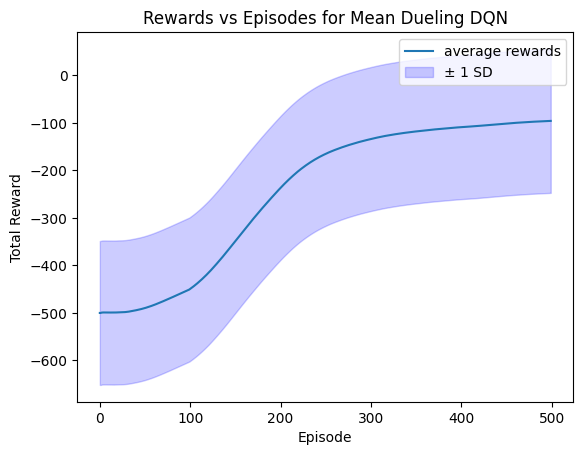

In [30]:
plot_rewards(average_mean_acrobot, "Mean Dueling DQN")

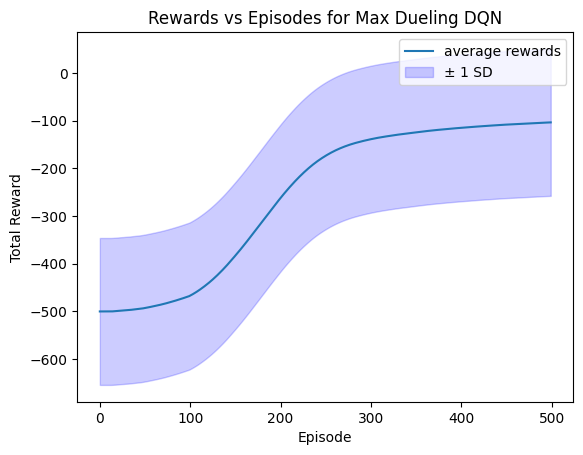

In [31]:
plot_rewards(average_max_acrobot, "Max Dueling DQN")